# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.  

Install new version of sliderule:  
"But if you do a **git pull** in your sliderule-python repo and then to a **python setup.py install**, it should resolve the issue."  
https://icesat-2sliderule.slack.com/archives/CTW2ESWFP/p1638199956016000

In [1]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
#import panel as pn
#pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import pandas as pd
from datetime import datetime
# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [4]:
SRwidgets?

Object `SRwidgets` not found.


In [5]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [6]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [7]:
polygon_gdf = gpd.read_file('../data/gm_west2.geojson', crs='epsg:4326')
polygon_gdf.head()

,geometry
0,"POLYGON ((-108.26134 39.05972, -108.25516 39.0..."


In [7]:
polygon_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

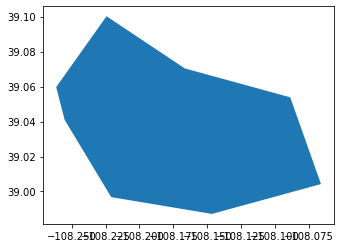

In [8]:
polygon_gdf[0:].plot()

In [29]:
polygon_gdf.type

0    Polygon
dtype: object

In [8]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(polygon_gdf[0:])
geodata = ipyleaflet.GeoData(geo_dataframe=polygon_gdf[0:])
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [9]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion(polygon_gdf)
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [10]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 11850 records


,rms_misfit,rgt,n_fit_photons,spot,delta_time,distance,w_surface_window_final,h_mean,cycle,h_sigma,dh_fit_dy,pflags,dh_fit_dx,segment_id,gt,geometry
time,,,,,,,,,,,,,,,,
2018-11-15 21:07:35.507301452,0.141154,737,34,6,2.755126e+07,4.338665e+06,3.0,2980.594716,1,0.025316,0.0,0,0.009144,216346,10,POINT (-108.11390 38.99189)
2018-11-15 21:07:35.510113648,0.163428,737,20,6,2.755126e+07,4.338685e+06,3.0,2980.577977,1,0.043345,0.0,0,-0.002196,216347,10,POINT (-108.11392 38.99207)
2018-11-15 21:07:35.512926608,0.141337,737,38,6,2.755126e+07,4.338705e+06,3.0,2980.610419,1,0.029030,0.0,0,-0.000247,216348,10,POINT (-108.11394 38.99225)
2018-11-15 21:07:35.515740568,0.118160,737,47,6,2.755126e+07,4.338725e+06,3.0,2980.507371,1,0.019512,0.0,0,-0.013711,216349,10,POINT (-108.11396 38.99243)
2018-11-15 21:07:35.639730580,0.167408,737,84,4,2.755126e+07,4.339708e+06,3.0,3181.441404,1,0.026280,0.0,0,-0.033441,216398,30,POINT (-108.07846 39.00397)


In [23]:
#gdf.time = pd.DatetimeIndex(gdf.time)
#gdf = gdf.set_index(['time'])
gdf.sort_index(inplace=True)
gdf['acqdate'] = gdf.index.date
gdf['acqdate_string'] = gdf['acqdate'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

In [25]:
gdf.head(2)

,distance,rgt,gt,spot,segment_id,pflags,delta_time,cycle,rms_misfit,w_surface_window_final,h_sigma,h_mean,n_fit_photons,dh_fit_dy,dh_fit_dx,geometry,acqdate,acqdate_string
time,,,,,,,,,,,,,,,,,,
2018-11-15 21:07:35.507301452,4.338665e+06,737,10,6,216346,0,2.755126e+07,1,0.141154,3.0,0.025316,2980.594716,34,0.0,0.009144,POINT (-108.11390 38.99189),2018-11-15,2018-11-15
2018-11-15 21:07:35.510113648,4.338685e+06,737,10,6,216347,0,2.755126e+07,1,0.163428,3.0,0.043345,2980.577977,20,0.0,-0.002196,POINT (-108.11392 38.99207),2018-11-15,2018-11-15


In [32]:
gdf.acqdate.unique()

array([datetime.date(2018, 11, 15), datetime.date(2018, 12, 13),
       datetime.date(2019, 7, 17), datetime.date(2019, 9, 11),
       datetime.date(2019, 11, 14), datetime.date(2020, 2, 12),
       datetime.date(2020, 3, 11), datetime.date(2020, 4, 14),
       datetime.date(2020, 5, 13), datetime.date(2020, 6, 10),
       datetime.date(2020, 7, 14), datetime.date(2020, 8, 12),
       datetime.date(2020, 11, 11), datetime.date(2020, 12, 8),
       datetime.date(2021, 3, 9), datetime.date(2021, 5, 12),
       datetime.date(2021, 8, 10), datetime.date(2021, 9, 7),
       datetime.date(2021, 10, 11), datetime.date(2022, 2, 8)],
      dtype=object)

In [25]:
gdf['elev_plus'] = gdf['h_mean'] + 1

In [33]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [19]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)


DatePicker(value=None, description='Pick a Date')

In [28]:
start_date = datetime(2018, 11, 10)
end_date = datetime(2022, 3, 1)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider


SelectionRangeSlider(description='Dates', index=(0, 1207), layout=Layout(width='500px'), options=((' 10 Nov 20…

In [21]:
SRwidgets.

Type:        widgets
String form: <sliderule.ipysliderule.widgets object at 0x7fa0e982b6a0>
File:        ~/opt/miniconda3/envs/sliderule/lib/python3.8/site-packages/sliderule-1.4.2-py3.8.egg/sliderule/ipysliderule.py
Docstring:   <no docstring>


In [30]:
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap='viridis',
    max_plot_points=10000, tooltip=True, colorbar=True)

ValueError: Can't clean for JSON: datetime.date(2018, 11, 15)

In [13]:
SRwidgets.

In [13]:
date = dict(zip(gdf[''].tolist(), africa[‘pop_est’].tolist()))
africa[[“name”, “geometry”]].to_file(“data/africa.json”, driver=”GeoJSON”, encoding=’utf-8')
geojson_data = json.load(open(“data/africa.json”,’r’))for feature in geojson_data[‘features’]:
     properties = feature[‘properties’]
     feature.update(id=properties[‘name’])
     #print(feature[‘id’])

SyntaxError: invalid character in identifier (853659073.py, line 1)

#### Create plots for a single track

In [ ]:
# selection for reference ground track
RGTs = [str(int(x)) for x in gdf.rgt.unique()]
SRwidgets.rgt = widgets.Dropdown(
    options=RGTs,
    value=RGTs[1], # You can change this with the pull-down widget below!
    description="RGT:",
    description_tooltip="RGT: Reference Ground Track to plot",
    disabled=False
)

# selection for ground track
ground_track_options = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]
SRwidgets.ground_track = widgets.Dropdown(
    options=ground_track_options,
    value='gt1l',
    description="Track:",
    description_tooltip="Track: Ground Track to plot",
    disabled=False
)      
widgets.VBox([
    SRwidgets.rgt,
    SRwidgets.ground_track,
])

In [19]:
gdf.index = gdf.index.astype(str)

In [17]:
gdf2.index

RangeIndex(start=0, stop=136513, step=1)

In [13]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_statewide/SlideRule_methow/notebooks


In [13]:
gdf.to_file('methow_all_sr-atl06_03302022.geojson', driver='GeoJSON')

In [14]:
gdf2 = gpd.read_file('../data/methow_all_sr-atl06_03302022.geojson')

In [15]:
gdf2.head()

,time,distance,dh_fit_dx,gt,spot,w_surface_window_final,h_mean,dh_fit_dy,n_fit_photons,pflags,cycle,h_sigma,rgt,rms_misfit,delta_time,segment_id,geometry
0,2018-11-09T22:09:43.662998,5.382001e+06,0.367318,20,1,9.386548,774.110259,0.0,41,0,1,0.079705,646,0.506044,2.703658e+07,268398,POINT (-120.00053 48.33917)
1,2018-11-09T22:09:43.789001,5.382903e+06,0.028568,20,1,3.000000,919.941824,0.0,42,0,1,0.050617,646,0.305572,2.703658e+07,268443,POINT (-120.00167 48.34723)
2,2018-11-09T22:09:43.794998,5.382943e+06,-0.116342,20,1,3.029108,918.460968,0.0,31,0,1,0.046853,646,0.240537,2.703658e+07,268445,POINT (-120.00172 48.34760)
3,2018-11-09T22:09:43.798000,5.382963e+06,-0.091024,20,1,3.000000,916.399163,0.0,39,0,1,0.059160,646,0.325805,2.703658e+07,268446,POINT (-120.00174 48.34778)
4,2018-11-09T22:09:43.799999,5.382983e+06,-0.027886,20,1,3.000000,915.721672,0.0,40,0,1,0.038990,646,0.245902,2.703658e+07,268447,POINT (-120.00177 48.34796)


<AxesSubplot:>

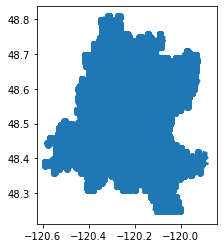

In [15]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
polygon_gdf.plot(ax=ax)